In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime

import json
import pickle

# Our generated code
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%load_ext autoreload
%autoreload 2
    
from libs import exploring as explore
from libs import visualising as visualize
from libs import cleansing as cleanse

In [100]:
# Import data
open_food_facts_csv_file = "./data/en.openfoodfacts.org.products.csv"

# Load list of columns (external file) that are loaded into pyspark
data = []
with open("./data/cleanse/columns_to_import.txt", "r") as json_data:
    columns_to_import = json.load(json_data)
    columns_to_import


food_facts_pd = pd.read_csv(open_food_facts_csv_file,
                            delimiter="\t",
                            usecols=columns_to_import.keys(),
                            dtype=columns_to_import,
                            index_col='code')

In [101]:
data_summary_string = "The dataset now comprises {} entries, of which we have {} features."
data_summary_string.format(food_facts_pd.shape[0], food_facts_pd.shape[1])

'The dataset now comprises 356027 entries, of which we have 22 features.'

# Explore the data

In [102]:
food_facts_pd.head(10)

,created_t,created_datetime,product_name,quantity,packaging,brands,categories,categories_tags,categories_en,origins,...,manufacturing_places_tags,labels,purchase_places,stores,countries_en,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,,,,,
0000000003087,1474103866,2016-09-17T09:17:46Z,Farine de blé noir,1kg,NaN,Ferme t'y R'nao,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN
0000000004530,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,2243.0,NaN,14,14
0000000004559,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,Torn & Glasser,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,1941.0,NaN,0,0
0000000016087,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,Grizzlies,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,2540.0,NaN,12,12
0000000016094,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,Bob's Red Mill,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,1552.0,NaN,NaN,NaN
0000000016100,1489055651,2017-03-09T10:34:11Z,Breadshop Honey Gone Nuts Granola,NaN,NaN,Unfi,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,1933.0,NaN,NaN,NaN
0000000016117,1489055730,2017-03-09T10:35:30Z,Organic Long Grain White Rice,NaN,NaN,Lundberg,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,1490.0,NaN,NaN,NaN
0000000016124,1489055711,2017-03-09T10:35:11Z,Organic Muesli,NaN,NaN,Daddy's Muesli,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,1833.0,NaN,7,7
0000000016193,1489055651,2017-03-09T10:34:11Z,Organic Dark Chocolate Minis,NaN,NaN,Equal Exchange,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,United States,NaN,2406.0,NaN,NaN,NaN


## Display number of NaN entries per column

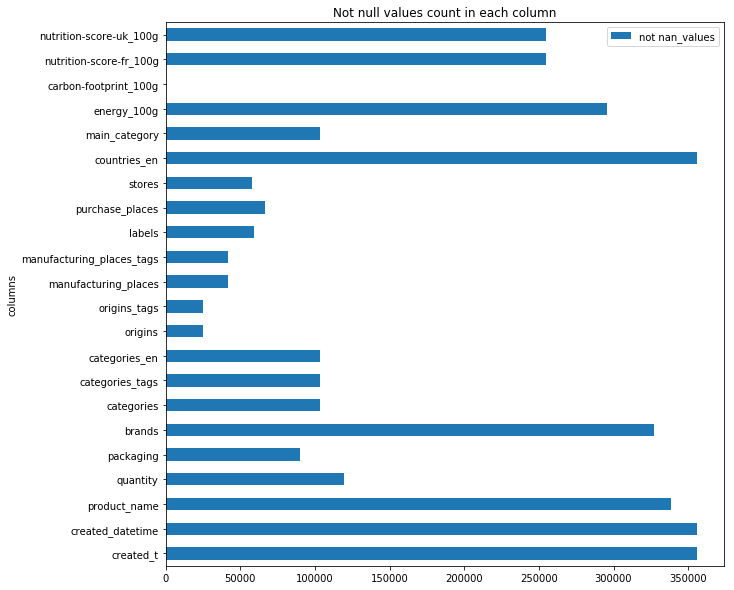

In [103]:
null_entries = pd.DataFrame({'columns' : food_facts_pd.columns,
                             'not nan_values' : [food_facts_pd[c].count() for c in food_facts_pd]
                            })

# Plot NaNs counts
null_entries.set_index('columns').plot(kind='barh', figsize=(10, 10))
plt.title("Not null values count in each column")
plt.show()

We see that there are many NaN entries in this data set. For our analysis, we can only use entries that have at least a product name, country tag, manufacturing and purchase place, and a created date tag. Unfortunately, we have to drop all columns, that lack those data. Because our interest lies in the carbon footprint, we have got a dataset of renadom samples from [Eaternity](http://www.eaternity.org/), providing a database for carrying out environmental calculations for menus.

In [104]:
no_rows_inital = food_facts_pd.shape[0]

# Drop entries with missing entries in of our main-features
essential_columns = ['created_t', 'product_name', 'countries_en', 'categories_en', 'manufacturing_places', 'purchase_places']
food_facts_pd = food_facts_pd.dropna(subset=essential_columns, )

no_rows_reduced_nan = food_facts_pd.shape[0]

# Also drop duplicated values (indentify based on index (barcode))
food_facts_pd = food_facts_pd.drop_duplicates()

no_rows_reduced_duplicates = food_facts_pd.shape[0]

print("{} entries were dropped, of which {} were duplicates."\
      .format(no_rows_inital-no_rows_reduced_duplicates, no_rows_reduced_nan-no_rows_reduced_duplicates))
print(data_summary_string.format(food_facts_pd.shape[0], food_facts_pd.shape[1]))

320916 entries were dropped, of which 0 were duplicates.
The dataset now comprises 35111 entries, of which we have 22 features.


Puhh, that was though. From now on, we are going to rescue the data and enrich wherever we can.

In [105]:
# Replace NaNs with emptry string
food_facts_pd = food_facts_pd.fillna("")

In [107]:
# Next lets look at the data types:
food_facts_pd.dtypes


created_t                            object
created_datetime             datetime64[ns]
product_name                         object
quantity                             object
packaging                            object
brands                               object
categories                           object
categories_tags                      object
categories_en                        object
origins                              object
origins_tags                         object
manufacturing_places                 object
manufacturing_places_tags            object
labels                               object
purchase_places                      object
stores                               object
countries_en                         object
main_category                        object
energy_100g                          object
carbon-footprint_100g                object
nutrition-score-fr_100g              object
nutrition-score-uk_100g              object
dtype: object

In [110]:
#Remove some erros, some created_time have supermarket names instead of time format
food_facts_pd = food_facts_pd[food_facts_pd['created_datetime'].map(len) == 19]
food_facts_pd['created_datetime'] = pd.to_datetime(food_facts_pd['created_datetime'])

food_facts_pd.dtypes

created_t                            object
created_datetime             datetime64[ns]
product_name                         object
quantity                             object
packaging                            object
brands                               object
categories                           object
categories_tags                      object
categories_en                        object
origins                              object
origins_tags                         object
manufacturing_places                 object
manufacturing_places_tags            object
labels                               object
purchase_places                      object
stores                               object
countries_en                         object
main_category                        object
energy_100g                          object
carbon-footprint_100g                object
nutrition-score-fr_100g              object
nutrition-score-uk_100g              object
dtype: object

Another thing that we are not really keen of are the language indicators, so we are going to remove those abbreviations.

In [111]:
def remove_language_indicator(row_str):
    tags = [tag if len(tag.split(':'))==1 else tag.split(':')[1] for tag in row_str.split(',')]
    return ",".join(tags)

In [112]:
food_facts_pd.categories_en = food_facts_pd.categories_en.apply(remove_language_indicator)
food_facts_pd.main_category = food_facts_pd.main_category.apply(remove_language_indicator)
food_facts_pd.countries_en = food_facts_pd.countries_en.apply(remove_language_indicator)

The next issue we are going to tackel are redudant columns. Especially here, these are similarly named columns ending with "_en", "_tags". We are handling this, by only importing columns that end with "_en" if we have the choice.

In [113]:
food_facts_pd

,created_t,created_datetime,product_name,quantity,packaging,brands,categories,categories_tags,categories_en,origins,...,manufacturing_places_tags,labels,purchase_places,stores,countries_en,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
code,,,,,,,,,,,,,,,,,,,,,


## Unitize tags
Many parts of the data are categorizations based on tags. However, those tags are in a variety of languages and string formattings, so in order to use them we attempt to group tags that hint to the same property and map them to a common indicator. 

Every column of the data set requires special treatment, as follows:

### Countries tags

In [ ]:
food_facts_pd = food_facts_pd.dropna(subset=['product_name', 'countries_en', 'stores'])

Note :  
- purchase_places and countries_en are the same though "countries_en" is more complete
-  manufacturing_places and origins are different

In [ ]:
countries = pd.read_csv("./data/country_lookup.csv")[['name', 'cca2', 'alias', 'Forced']]

In [ ]:
#example
copy_purchases_places = food_facts_pd[['purchase_places']].iloc[:2000, :]
copy_purchases_places = copy_purchases_places.replace('', "Unknown", regex=True)
copy_purchases_places['Filtered'] = copy_purchases_places.purchase_places.apply(lambda x: cleanse.country_name_filter(x, countries))
copy_purchases_places

In [ ]:
visualize.plot_occurences_of_distinct_values(food_facts_pd, 'countries_en')

### Labels tags

In [ ]:
# Unitze labels
with open('./data/cleanse/taxonomies.json', 'r') as json_data:
    labels_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.labels = food_facts_pd.labels.apply(lambda x: [labels_lookup[z] for z in x.split(',')])

In [ ]:
visualize.plot_occurences_of_distinct_values(food_facts_pd, 'labels')

### Store labels tags

In [ ]:
# Unitize store labels
with open('./data/cleanse/stores_lookup.json', 'r') as json_data:
    stores_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.stores = food_facts_pd.stores.fillna("").apply(lambda x: [stores_lookup[z] for z in x.split(',')])

In [ ]:
visualize.plot_occurences_of_distinct_values(food_facts_pd, 'stores')

### Food category tags

In [ ]:
food_facts_pd.stores[1]

# Write clean data frame to CSV file

In [ ]:
# Generate a dataframe that extracts all information required by the web crawler
if 1==0: # skip cell
    products = food_facts_pd

    products.to_pickle("./web_crawler/products_pd.pickle")

In [ ]:
# Write to CSV file
clean_data_file_name = "./data/openfoodfacts_clean.csv"
food_facts_pd.to_csv(clean_data_file_name, sep=',', encoding='utf-8')